<a href="https://colab.research.google.com/github/raz0208/Techniques-For-Text-Analysis/blob/main/Word2VecModelwithSkip_Grams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Word2Vec & Skip-gram Overview
Word2Vec is a popular neural network-based model for learning word embeddings (vector representations of words) from a large corpus of text. It captures semantic relationships between words, meaning words with similar meanings have similar vector representations.

### Word2Vec has two main training architectures:

- CBOW (Continuous Bag of Words) – Predicts a target word from its surrounding context words.
- Skip-gram – Predicts surrounding context words given a target word.

### Skip-gram Model
Skip-gram is a training strategy used in Word2Vec that works as follows:

- Given a target word, the model predicts the context words (words that appear nearby in the sentence).
- It learns to maximize the probability of correctly predicting these context words.

### Word2Vec Model with Skip-Grams

Step 1: Import libraries and read data

In [12]:
# Import required libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import re
import io
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Load and Read Data
sentences = ["The quick brown fox jumps over the lazy dog.",
             "The dog barked at the fox!",
             "The fox ran away from the dog."]

### Step 2: Text Standardization

In [3]:
# Text Standardization
def custom_standardization(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)  # Remove special characters
    return text

standardized_sentences = [custom_standardization(sentence) for sentence in sentences]

print(standardized_sentences)

['the quick brown fox jumps over the lazy dog', 'the dog barked at the fox', 'the fox ran away from the dog']


Step 3: Tokenization & Vectorization
- Use TextVectorization to transform text into integer tokens.

In [4]:
# Tokenization & Vectorization
vocab_size = 10000
sequence_length = 10

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorizer.adapt(standardized_sentences)
vocab = np.array(vectorizer.get_vocabulary())
word_index = {word: i for i, word in enumerate(vocab)}

sequences = vectorizer(standardized_sentences).numpy()

sequences

array([[ 2,  6, 11,  3,  9,  7,  2,  8,  4,  0],
       [ 2,  4, 12, 14,  2,  3,  0,  0,  0,  0],
       [ 2,  3,  5, 13, 10,  2,  4,  0,  0,  0]])

Step 4: Generate Skip-Grams with Negative Sampling
- Create (target, context) word pairs using window size.
- Include negative sampling to train the model efficiently.

In [5]:
# Generate Skip-Grams with Negative Sampling
window_size = 2
num_ns = 4  # Number of negative samples

def generate_skip_grams(sequences, window_size, num_ns):
    targets, contexts, labels = [], [], []
    for sequence in sequences:
        for i, target_word in enumerate(sequence):
            if target_word == 0:  # Skip padding tokens
                continue

            context_start = max(0, i - window_size)
            context_end = min(len(sequence), i + window_size + 1)
            context_words = [sequence[j] for j in range(context_start, context_end) if j != i]

            for context_word in context_words:
                targets.append(target_word)
                contexts.append(context_word)
                labels.append(1)  # Positive example

                # Negative Sampling
                for _ in range(num_ns):
                    negative_sample = np.random.randint(1, len(vocab))
                    while negative_sample in context_words:
                        negative_sample = np.random.randint(1, len(vocab))

                    targets.append(target_word)
                    contexts.append(negative_sample)
                    labels.append(0)  # Negative example

    return np.array(targets), np.array(contexts), np.array(labels)

targets, contexts, labels = generate_skip_grams(sequences, window_size, num_ns)

targets, contexts, labels

(array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 

### Step 5: Build the Word2Vec Model
- Create an embedding layer for both target & context words.

In [6]:
# Build the Word2Vec Model
embedding_dim = 128

class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="w2v_embedding")
        self.context_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dot = tf.keras.layers.Dot(axes=1)
        self.flatten = tf.keras.layers.Flatten()

    def call(self, pair):
        target, context = pair
        target_emb = self.target_embedding(target)
        context_emb = self.context_embedding(context)
        dot_product = self.dot([target_emb, context_emb])
        return self.flatten(dot_product)

model = Word2Vec(vocab_size, embedding_dim)



### Step 6: Train the Model
- Compile using Adam optimizer & categorical cross-entropy loss.

In [7]:
# Train the Model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(10000).batch(512)

history = model.fit(dataset, epochs=100)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8000 - loss: 0.6933
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8000 - loss: 0.6916
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8000 - loss: 0.6899
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8000 - loss: 0.6881
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8000 - loss: 0.6863
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8000 - loss: 0.6844
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8000 - loss: 0.6824
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8000 - loss: 0.6803
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8000 - loss: 0.6779
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8000 - loss: 0.6753
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8000 - loss: 0.6725
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8000 - loss: 0.6695


### Step 7: Extract Word Embeddings

In [8]:
# Extract Word Embeddings
word_vectors = model.target_embedding.get_weights()[0]

word_vectors

array([[ 0.02752728, -0.04048985, -0.01408998, ..., -0.00836159,
        -0.02336323, -0.00289302],
       [ 0.04622001, -0.04658376,  0.04250329, ..., -0.01266775,
        -0.02096418,  0.03243553],
       [-0.13200492,  0.23403868,  0.19183306, ...,  0.05406319,
         0.1936958 ,  0.10118015],
       ...,
       [-0.00914239,  0.03304801,  0.01090962, ..., -0.02162124,
         0.0220031 ,  0.0420482 ],
       [ 0.01914733,  0.01411153, -0.00953121, ..., -0.041229  ,
         0.03964793,  0.01405275],
       [ 0.00364292, -0.03230484, -0.04416368, ..., -0.01410594,
        -0.0304368 , -0.04083145]], dtype=float32)

### Step 8: Save Embeddings & Metadata

In [9]:
# Save Embeddings & Metadata
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')
for i, word in enumerate(vocab):
    if i == 0: continue  # Skip padding token
    vec = word_vectors[i]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

print("Word embeddings saved!")

Word embeddings saved!


### Step 9: Evaluate the Model

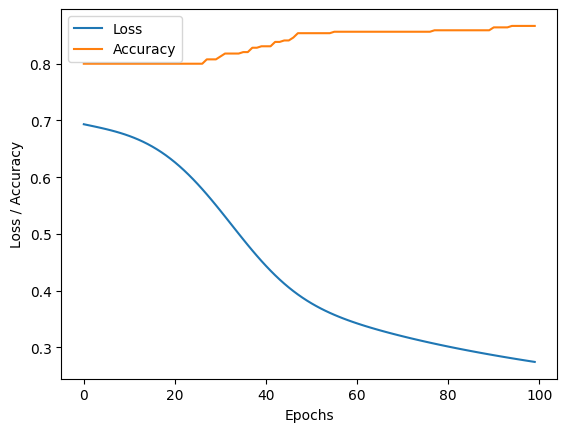

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


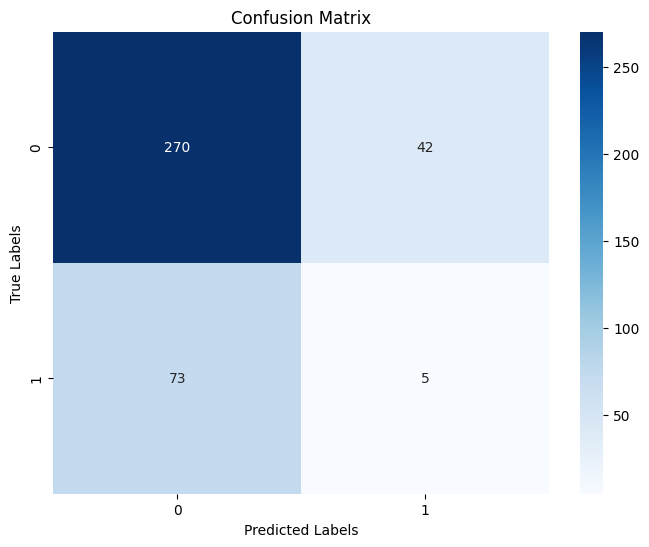

In [13]:
# Evaluate the Model
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

# Evaluate on the training data to get predictions for confusion matrix
predictions = model.predict(dataset)
predicted_labels = (predictions > 0).astype(int)

# Create confusion matrix
cm = confusion_matrix(labels, predicted_labels)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

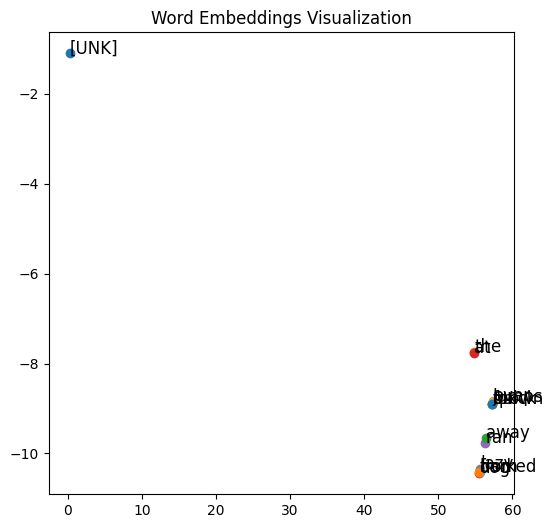

In [15]:
# Visualize Word Embeddings using t-SNE
def plot_embeddings(word_vectors, vocab):
    tsne = TSNE(n_components=2, random_state=0)
    reduced_embeddings = tsne.fit_transform(word_vectors[1:])  # Skip padding token
    plt.figure(figsize=(6, 6))
    for i, label in enumerate(vocab[1:]):  # Skip padding token
        x, y = reduced_embeddings[i]
        plt.scatter(x, y)
        plt.annotate(label, (x, y), fontsize=12)
    plt.title("Word Embeddings Visualization")
    plt.show()

plot_embeddings(word_vectors, vocab)